## Decision tree
- The purpose is to learn about classification algorithms like decision tree and logistic regression; also, to learn to evaluate predictions from classification using metrics

### Goals of prediction
1. To avoid, such as
    - which customers are likely to leave the company when their contracts expire.
    - Potential customers are likely to write-off (default)
    - Which web pages contain questionable contents
2. To target, such as
    - Which consumers are likely to respond to ads
    - Which web pages are most appropriate for the search query
     
### Informative attributes
- Attribute is the property of data
- Informative attribute provides information that reduces uncertainty about something
- The better the information, the more uncertainty is reduced

### Purity
- Technically, we would like the group to be as pure as possible
- Pure means homogeneous with respect to the target variable
- If some member in the group has a different target then the group is impure

### Entropy
- Entropy is a measure of disorder that can be applied to a set, such as one of our individual segments
- Disorder corresponds to how mixed (impure) the segment is with respect to the target
- More technically, entropy is defined as 
<center>
$ entropy = - p_1log(p_1) - p_2log(p_2) - p_3log(p_3)... $
</center>
- Each $p_i$ is the probability (the relative percentage) of the target class $i$

### Information Gain
- Entropy is only part of the story. We would like to measure how informative an attribute is with respect to target i.e. how much gain in information it gives us about the target
- Information gain (IG) measure how much attribute improves (decreases) entropy over the whole segmentation it creates
- In our context, IG measures the change in entropy due to further splitting

<center>
$IG(parent, children) = entropy(parent) – [p(c_1)×entropy(c_1) + p(c_2)×entropy(c_2) + ...]$
</center>

- The entropy for each child $(c_i)$ is weighted by the proportion of instances belonging to that child, $p(c_i)$

### Import libraries

In [1]:
library(tidyverse)
library(rpart) # decision tree
library(rpart.plot)
library(caret) # classification performance

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




### Configure defaults

In [2]:
options(repr.plot.width = 14, repr.plot.height = 8) # set plot size

### Read data

In [3]:
hr_data <- read.csv('~/Downloads/data-models/Lecture 11 - Decision tree/HR-Employee-Attrition.csv')
head(hr_data)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


In [4]:
hr_data1 <- hr_data %>%
select(
    -EmployeeCount,
    -EmployeeNumber, 
    -Over18,
    -StandardHours
) %>%
mutate_if(is.character, as.factor)

head(hr_data1)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


### Data splitting
- Hold-out method
    - Training set: used to train the classifier
    - Test set: used to estimate the error rate of the trained classifier

In [5]:
set.seed(555)

test_ind <- sample(nrow(hr_data1), 0.3 * nrow(hr_data1))

hrData_training <- hr_data1[-test_ind,]
hrData_testing <- hr_data1[test_ind,]

### Model training

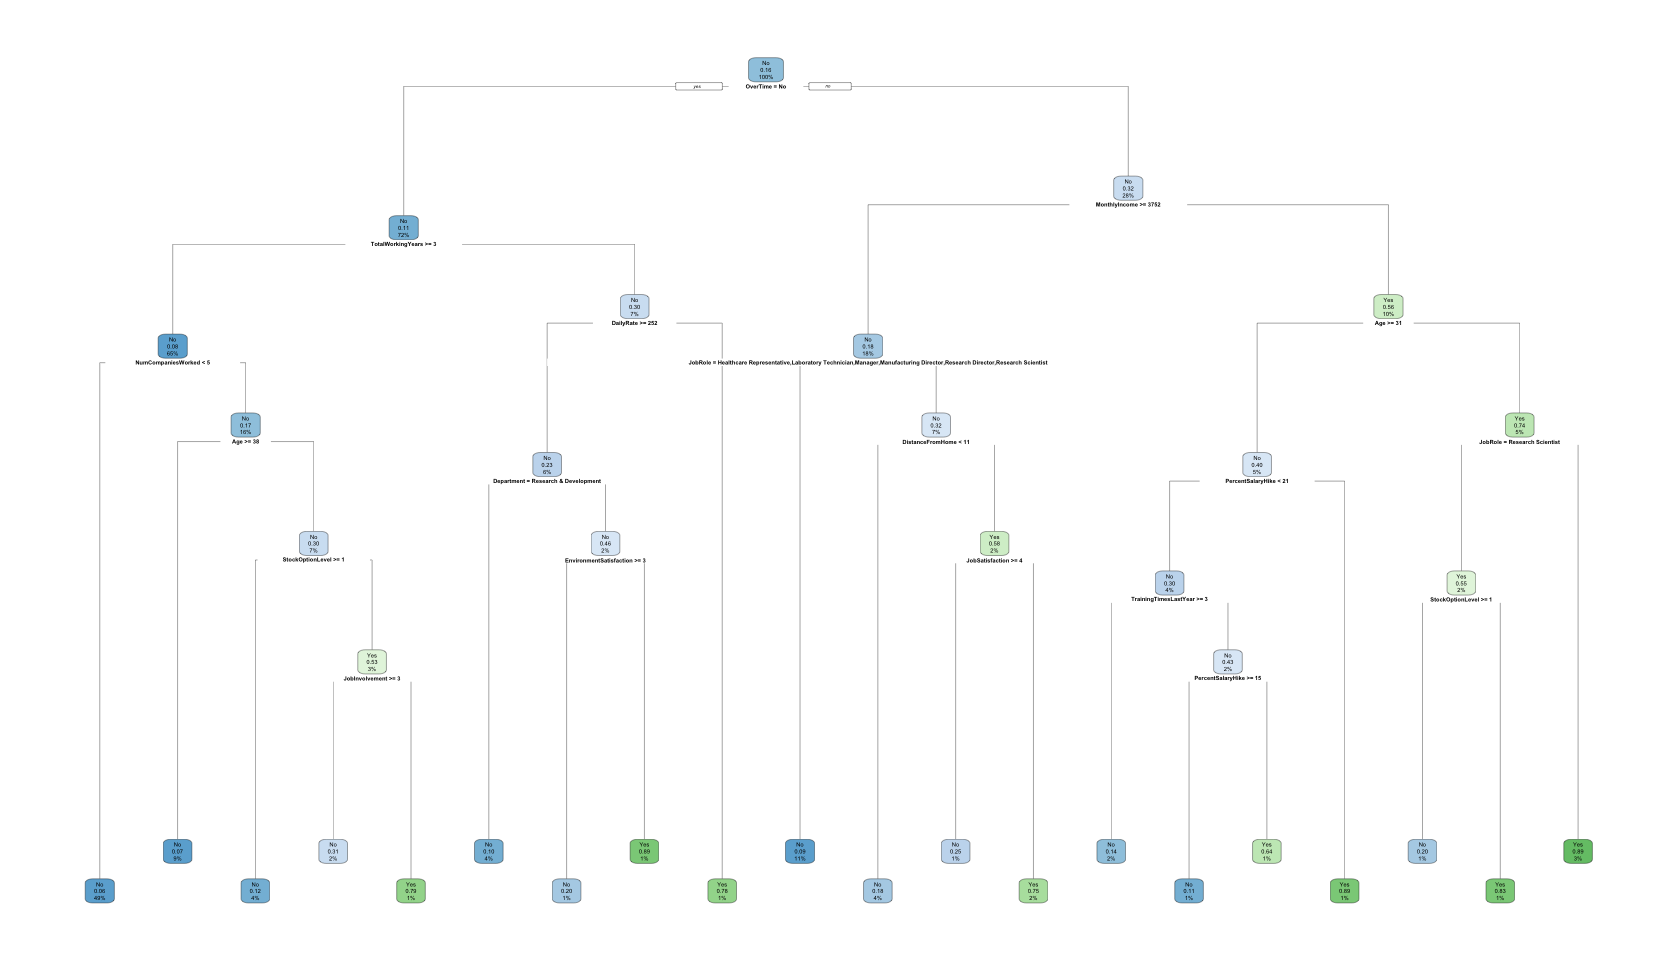

In [6]:
tree <- rpart(Attrition ~ ., data = hrData_training)
rpart.plot(tree)

In [7]:
tree$variable.importance

MonthlyIncome                  JobRole                 OverTime 
              26.1896487               23.3603170               18.4158494 
                JobLevel        TotalWorkingYears                      Age 
              18.1714413               17.8597923               17.7295790 
              Department         StockOptionLevel         DistanceFromHome 
              10.3110720               10.0924242                9.8234053 
           MaritalStatus                DailyRate        PercentSalaryHike 
               8.9742103                8.8632315                8.3605296 
 EnvironmentSatisfaction           JobInvolvement       NumCompaniesWorked 
               6.5551131                5.2063233                4.7142487 
         JobSatisfaction               HourlyRate           EducationField 
               4.0998299                3.8226467                3.8184670 
          YearsAtCompany        PerformanceRating                Education 
               3.6781803                3.5083540                3.0910881 
      YearsInCurrentRole RelationshipSatisfaction    TrainingTimesLastYear 
               2.9446058                2.5061994                2.4968681 
             MonthlyRate  YearsSinceLastPromotion           BusinessTravel 
               2.0950753                1.7503030                1.6594460 
         WorkLifeBalance                   Gender     YearsWithCurrManager 
               1.1864198                1.0326662                0.6258913

### Prediction

In [8]:
head(predict(tree, hrData_testing))

,No,Yes
497,0.9426877,0.05731225
344,0.8181818,0.18181818
400,0.9426877,0.05731225
1373,0.9426877,0.05731225
369,0.2500000,0.75000000
117,0.9426877,0.05731225


In [9]:
res <- predict(tree, hrData_testing, type = 'class')
head(res)

497  344  400 1373  369  117 
  No   No   No   No  Yes   No 
Levels: No Yes

### Evaluation
- A confusion matrix consist of
    - `TP` : True positive, actual target = `Positive`, prediction = `Positive`
    - `FP` : False positive, actual target = `Negative`, prediction = `Positive`
    - `FN` : False negative, actual target = `Positive`, prediction = `Negative`
    - `TN` : True negative, actual target = `Negative`, prediction = `Negative`
<br><br>
- Accuracy = $ \frac{TP + TN}{TP + TN + FP + FN} $ <br><br>
- 95% CI = interval with `95 percent` chance of containing true accuracy <br><br>
- Precision = $ \frac{TP}{TP + FP} $ <br><br>
- Recall = $ \frac{TP}{TP + FN} $ <br><br>
- F1 = $ \frac{2 * precision * recall}{precision + recall} $ <br><br>
- Sensitivity = $ \frac{TP}{TP + FN} $ same as recall <br><br>
- Specificity = $ \frac{TN}{TN + FP} $ <br><br>
- Prevalence = $ \frac{TP + FN}{TP + TN + FP + FN} $ <br><br>
- Detection Rate = $ \frac{TP}{TP + TN + FP + FN} $ <br><br>
- Detection Prevalence = $ \frac{TP + FP}{TP + TN + FP + FN} $ <br><br>
- Balanced Accuracy = $ \frac{sensitivity + specificity}{2} $ <br><br>
- Kappa = $\frac{accuracy - p_e}{1 - p_e}$ <br><br>
    - where $p_e = p_{positive} + p_{negative} $ = expected accuracy from random assignment <br><br>
        - $p_{positive} = \frac{TP + FP}{TP + TN + FP + FN} * \frac{TP + FN}{TP + TN + FP + FN}$ <br><br>
        - $p_{negative} = \frac{TN + FN}{TP + TN + FP + FN} * \frac{TN + FP}{TP + TN + FP + FN}$ <br><br>
    - Kappa can be from `-1` to `1`, the higher the better where `Kappa <= 0` means model is not better than random assignment <br><br>
- No Information Rate = proportion of majority class
- `P-Value [Acc > NIR]` = probability that Accuracy > No Information Rate is by chance

In [10]:
confusionMatrix(res, hrData_testing$Attrition, positive = 'Yes', mode = 'prec_recall')

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  356  51
       Yes  17  17
                                          
               Accuracy : 0.8458          
                 95% CI : (0.8087, 0.8782)
    No Information Rate : 0.8458          
    P-Value [Acc > NIR] : 0.5323          
                                          
                  Kappa : 0.257           
                                          
 Mcnemar's Test P-Value : 6.285e-05       
                                          
              Precision : 0.50000         
                 Recall : 0.25000         
                     F1 : 0.33333         
             Prevalence : 0.15420         
         Detection Rate : 0.03855         
   Detection Prevalence : 0.07710         
      Balanced Accuracy : 0.60221         
                                          
       'Positive' Class : Yes             
                                          

## Logistic regression
- When the ordinal/numeric input associating with categorical dependent variable, logistic regression can be used
- Suitable when
    - Number of features is large or
    - Number of observations is large

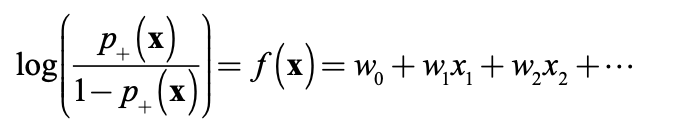

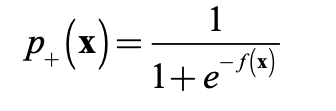

- where $x_i$ is i th feature 

### Model training

In [11]:
logitModel <- glm(Attrition ~ ., family = "binomial", data = hrData_training) # binary output
logitModel


Call:  glm(formula = Attrition ~ ., family = "binomial", data = hrData_training)

Coefficients:
                     (Intercept)                               Age  
                      -1.030e+01                        -2.365e-02  
 BusinessTravelTravel_Frequently       BusinessTravelTravel_Rarely  
                       1.612e+00                         8.733e-01  
                       DailyRate  DepartmentResearch & Development  
                      -1.284e-04                         1.325e+01  
                 DepartmentSales                  DistanceFromHome  
                       1.322e+01                         3.510e-02  
                       Education       EducationFieldLife Sciences  
                       4.396e-02                        -7.984e-01  
         EducationFieldMarketing             EducationFieldMedical  
                      -4.005e-01                        -8.998e-01  
             EducationFieldOther    EducationFieldTechnical Degree  
      

### Prediction

In [12]:
logit_result <- predict(logitModel, hrData_testing, type = 'response') # predict probability
res <- factor(ifelse(logit_result > 0.15, 'Yes', 'No'), level = c('No','Yes')) # cut-off at 0.15
head(res, n = 5)

497  344  400 1373  369 
 Yes   No  Yes   No  Yes 
Levels: No Yes

### Evaluation

In [13]:
confusionMatrix(res, hrData_testing$Attrition, positive = 'Yes',mode = 'prec_recall')

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  282  18
       Yes  91  50
                                          
               Accuracy : 0.7528          
                 95% CI : (0.7098, 0.7924)
    No Information Rate : 0.8458          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3415          
                                          
 Mcnemar's Test P-Value : 5.336e-12       
                                          
              Precision : 0.3546          
                 Recall : 0.7353          
                     F1 : 0.4785          
             Prevalence : 0.1542          
         Detection Rate : 0.1134          
   Detection Prevalence : 0.3197          
      Balanced Accuracy : 0.7457          
                                          
       'Positive' Class : Yes             
                                          